If on google collab, if not skip the following cell

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/TFG_Matematicas'

Mounted at /content/gdrive
/content/gdrive/MyDrive/TFG_Matematicas


## Preparation to test models

In [4]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, SimpleRNN, LSTM, Input, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
from utils.utils import *


In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
print("All devices: ", tf.config.list_logical_devices('TPU'))
tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [6]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
train_idxs = read_indexes('./utils/train.txt')
validation_idxs =  read_indexes('./utils/validation.txt')
test_idxs = read_indexes('./utils/test.txt')

In [8]:
data_indexes = [(i+1,j+1) for i in range(10) for j in range(2000)]
parameters = load_parameter_list()
df_parameters = pd.DataFrame(parameters, columns=['cx', 'cy', 'a', 'b', 'theta', 'e1', 'e2'])
df_parameters['data_index'] = data_indexes

y_train = df_parameters[df_parameters['data_index'].isin(train_idxs)].drop('data_index', axis = 1)
y_validation = df_parameters[df_parameters['data_index'].isin(validation_idxs)].drop('data_index', axis = 1)
y_test = df_parameters[df_parameters['data_index'].isin(test_idxs)].drop('data_index', axis = 1)

In [9]:
X_train = np.array(load_data_multithreaded(train_idxs,100, small = True))
print('train loaded')
X_validation = np.array(load_data_multithreaded(validation_idxs,100, small = True))
print('validation loaded')
X_test = np.array(load_data_multithreaded(test_idxs,100, small = True))
print('test loaded')

train loaded
validation loaded
test loaded


In [10]:
mean = np.mean(X_train.flatten())
std = np.std(X_train.flatten())

In [11]:
mean, std

(0.00289415908159017, 0.015852358244609798)

# Preparing metrics

In [14]:
def e1_mse(y_true, y_pred):
    output = y_pred[:, -2]
    output_mae = tf.keras.metrics.mean_squared_error(y_true[:, -2], output)
    return output_mae
def e2_mse(y_true, y_pred):
    output = y_pred[:, -1]
    output_mae = tf.keras.metrics.mean_squared_error(y_true[:, -1], output)
    return output_mae

def e1_mae(y_true, y_pred):
    output = y_pred[:, -2]
    output_mae = tf.keras.metrics.mean_absolute_error(y_true[:, -2], output)
    return output_mae
def e2_mae(y_true, y_pred):
    output = y_pred[:, -1]
    output_mae = tf.keras.metrics.mean_absolute_error(y_true[:, -1], output)
    return output_mae

def e1_rmse(y_true, y_pred):
    output = y_pred[:, -2]
    output_rmse = rmse(y_true[:, -2], output)
    return output_rmse
def e2_rmse(y_true, y_pred):
    output = y_pred[:, -1]
    output_rmse = rmse(y_true[:, -1], output)
    return output_rmse

def e1_r2score(y_true, y_pred):
    output = y_pred[:, -2]
    output_rmse = r_squared(y_true[:, -2], output)
    return output_rmse
def e2_r2score(y_true, y_pred):
    output = y_pred[:, -1]
    output_rmse = r_squared(y_true[:, -1], output)
    return output_rmse

In [15]:
METRICS=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),
         tf.keras.metrics.MeanAbsoluteError(name='mae'),
         tf.keras.metrics.R2Score(name='r2score'),
         e1_mse,e2_mse,e1_mae,e2_mae,e1_rmse,e2_rmse, e1_r2score, e2_r2score]


# Feedforward model

In [11]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 11.9 MB/s eta 0:00:00


In [12]:
import visualkeras

In [13]:
model_version = '1'

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 7480)              0         
                                                                 
 dense (Dense)               (None, 1024)              7660544   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 7)                 4

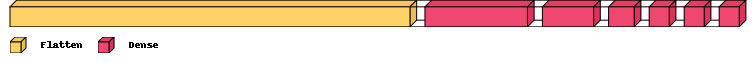

In [14]:
#with tpu_strategy.scope(): , WandbMetricsLogger(log_freq=5)
  # Feedforward model
#with tf.device('/device:GPU:0'):
feedforward = tf.keras.Sequential([
    Input(shape=(440, 17)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7)
])

feedforward.compile(optimizer='adam', loss='mse', metrics=[METRICS])
feedforward.summary()
plot_model(feedforward, to_file=f'figures/feedforward_{model_version}.png', show_shapes=True, show_layer_names=False)
visualkeras.layered_view(feedforward, legend=True, to_file=f'figures/feedforward_{model_version}_3d.png', spacing = 15)

In [15]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, restore_best_weights=True)
history = feedforward.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, verbose = 1, callbacks=[early_stopping])


Epoch 1/100
265/265 [==============================] - 8s 10ms/step - loss: 1.3687 - rmse: 1.1699 - mae: 0.7836 - r2score: 1.6114e-04 - e1_mse: 2.0387 - e2_mse: 5.0272 - e1_mae: 1.1031 - e2_mae: 1.8799 - e1_rmse: 1.3846 - e2_rmse: 2.2126 - e1_r2score: -0.3998 - e2_r2score: -0.0194 - val_loss: 1.0395 - val_rmse: 1.0196 - val_mae: 0.6786 - val_r2score: 0.2275 - val_e1_mse: 1.2379 - val_e2_mse: 4.0949 - val_e1_mae: 0.7969 - val_e2_mae: 1.7000 - val_e1_rmse: 1.0839 - val_e2_rmse: 2.0102 - val_e1_r2score: -1.1862 - val_e2_r2score: -0.1529
Epoch 2/100
265/265 [==============================] - 2s 8ms/step - loss: 0.9987 - rmse: 0.9993 - mae: 0.6424 - r2score: 0.3080 - e1_mse: 1.2674 - e2_mse: 4.1834 - e1_mae: 0.8285 - e2_mae: 1.7073 - e1_rmse: 1.1080 - e2_rmse: 2.0311 - e1_r2score: -1.1010 - e2_r2score: -0.1937 - val_loss: 0.8964 - val_rmse: 0.9468 - val_mae: 0.6184 - val_r2score: 0.3544 - val_e1_mse: 1.1912 - val_e2_mse: 3.6941 - val_e1_mae: 0.8436 - val_e2_mae: 1.6029 - val_e1_rmse: 1.0703

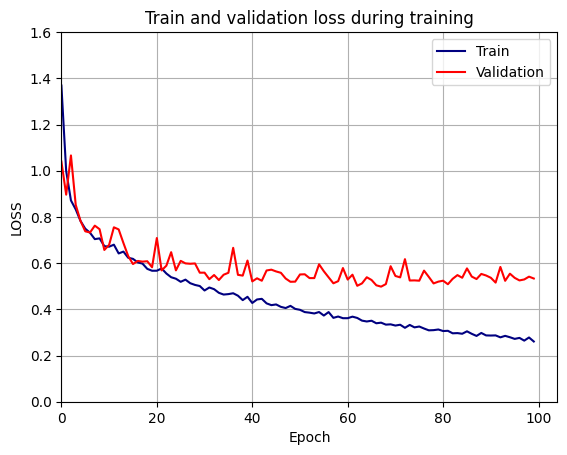

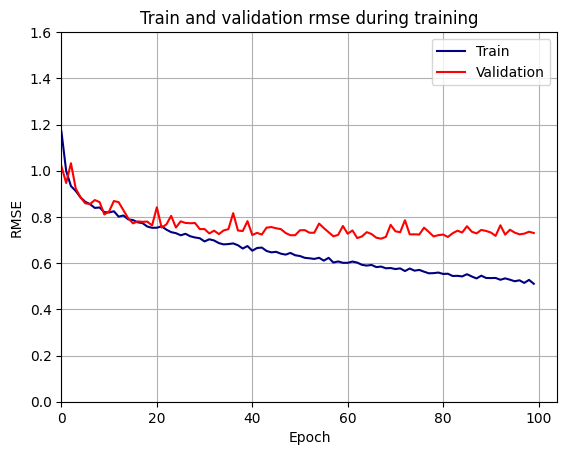

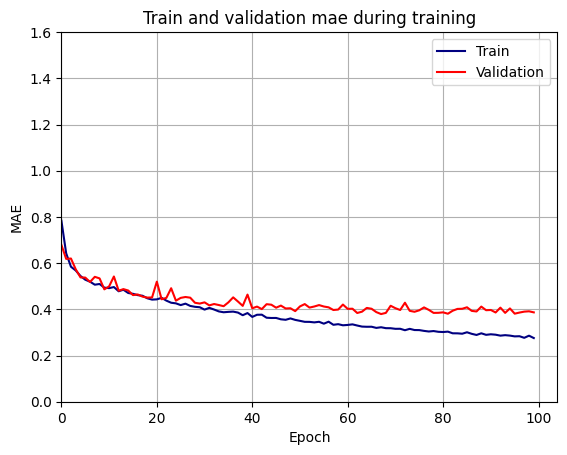

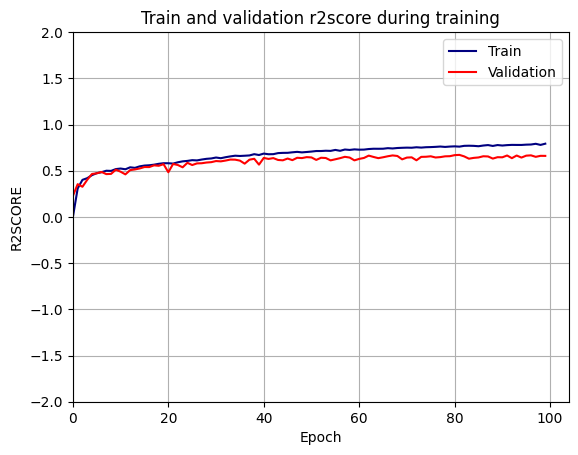

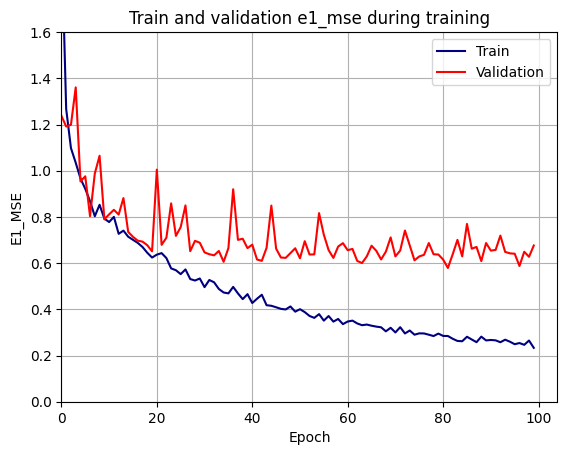

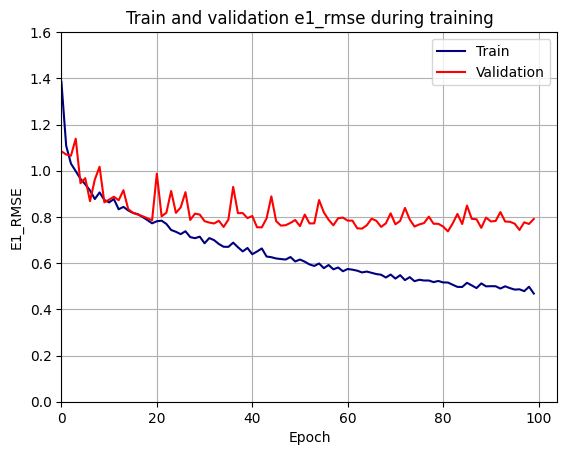

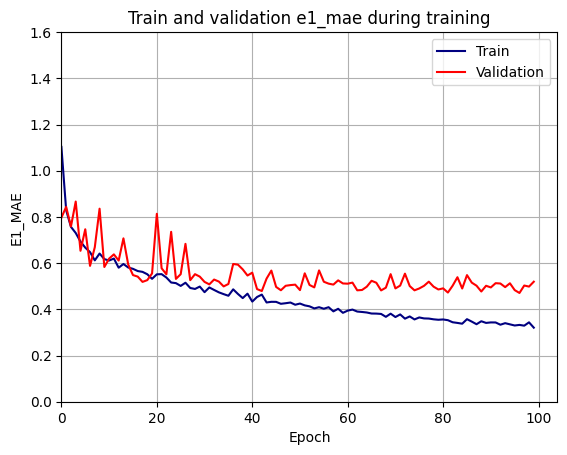

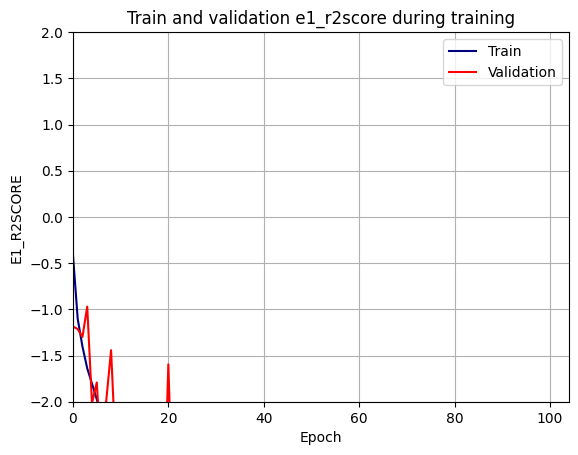

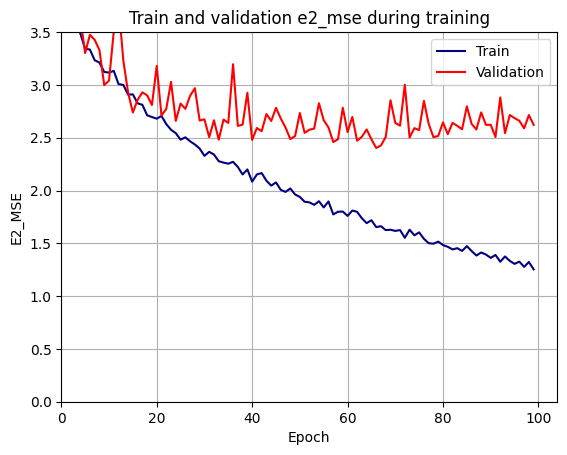

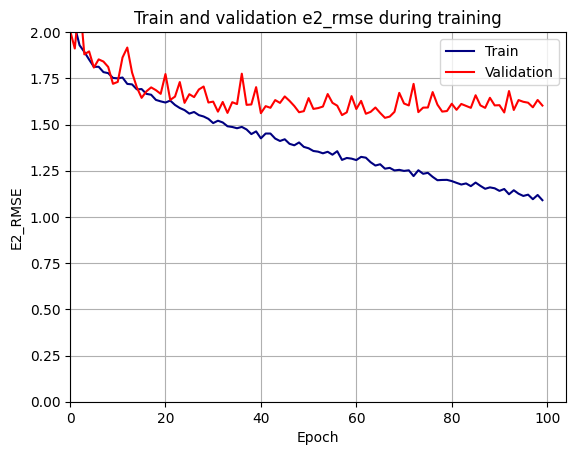

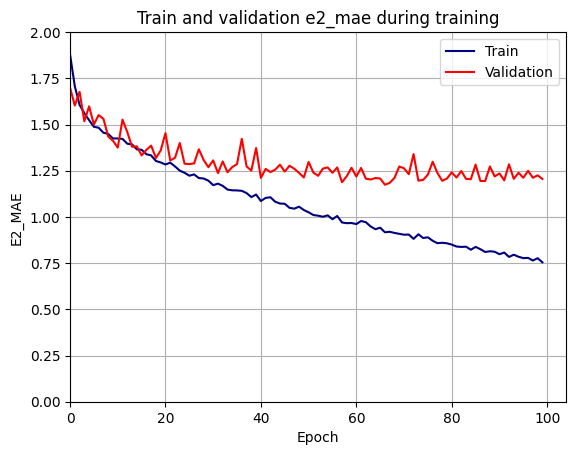

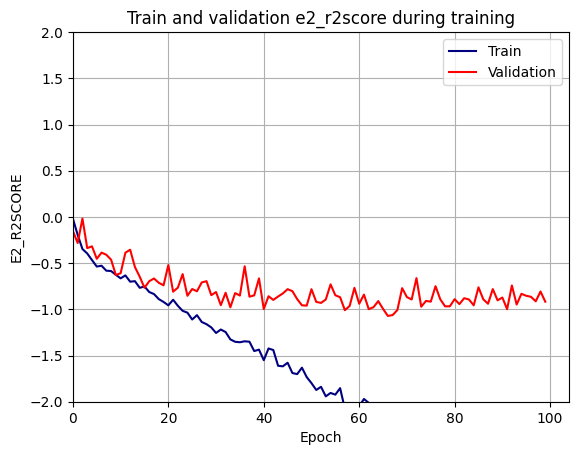

In [16]:
model = 'feedforward'
variation = 'small'
plot_metrics(history, 'loss', file = f'./figures/mse_{variation}_{model}_{model_version}')
plot_metrics(history, 'rmse', file = f'./figures/rmse_{variation}_{model}_{model_version}')
plot_metrics(history, 'mae', file = f'./figures/mae_{variation}_{model}_{model_version}')
plot_metrics(history, 'r2score', file = f'./figures/r2score_{variation}_{model}_{model_version}', lim_y_bottom = -2, lim_y_top = 2)
plot_metrics(history, 'e1_mse', file = f'./figures/e1_mse_{variation}_{model}_{model_version}')
plot_metrics(history, 'e1_rmse', file = f'./figures/e1_rmse_{variation}_{model}_{model_version}')
plot_metrics(history, 'e1_mae', file = f'./figures/e1_mae{variation}_{model}_{model_version}')
plot_metrics(history, 'e1_r2score', file = f'./figures/e1_r2score_{variation}_{model}_{model_version}', lim_y_bottom = -2, lim_y_top = 2)
plot_metrics(history, 'e2_mse', file = f'./figures/e2_mse_{variation}_{model}_{model_version}', lim_y_top = 3.5)
plot_metrics(history, 'e2_rmse', file = f'./figures/e2_rmse_{variation}_{model}_{model_version}', lim_y_top = 2)
plot_metrics(history, 'e2_mae', file = f'./figures/e2_mae_{variation}_{model}_{model_version}', lim_y_top = 2)
plot_metrics(history, 'e2_r2score', file = f'./figures/e2_r2score_{variation}_{model}_{model_version}', lim_y_bottom = -2, lim_y_top = 2)

In [17]:
model_evaluation(feedforward, X_test, y_test, random_samples = 10)

89/89 [==============================] - 0s 3ms/step - loss: 0.5533 - rmse: 0.7438 - mae: 0.3951 - r2score: 0.6583 - e1_mse: 0.6297 - e2_mse: 2.7509 - e1_mae: 0.5199 - e2_mae: 1.2420 - e1_rmse: 0.7706 - e2_rmse: 1.6420 - e1_r2score: -3.7660 - e2_r2score: -0.9162
Test mse: 0.5532532930374146
Test rmse: 0.7438099980354309
Test mae: 0.3950920104980469
Test R2: 0.6583186984062195
89/89 [==============================] - 0s 2ms/step
Metrics for parameters e1 and e2:
Parameter e1:
  	MSE: 0.632, RMSE: 0.795, MAE: 0.632, R2: -3.088
Parameter e2:
  	MSE: 2.761, RMSE: 1.662, MAE: 7.914, R2: -0.855
1/1 [==============================] - 0s 21ms/step

Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 0.398	3.018	0.737	0.421	0.211	1.918	3.790
prediction:	 0.191	2.932	0.668	0.390	0.229	2.192	5.628
------------
real:		 2.628	5.172	1.051	0.721	-0.363	1.819	1.268
prediction:	 2.615	5.745	1.188	0.382	0.334	4.755	1.821
------------
real:		 0.958	4.753	1.583	0.504	0.266	1.

# Convolutional model

In [18]:
model_version = '1'

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 440, 17, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 440, 17, 32)       128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 440, 8, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 440, 8, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 440, 8, 64)        256       
 chNormalization)                                                
                                                      

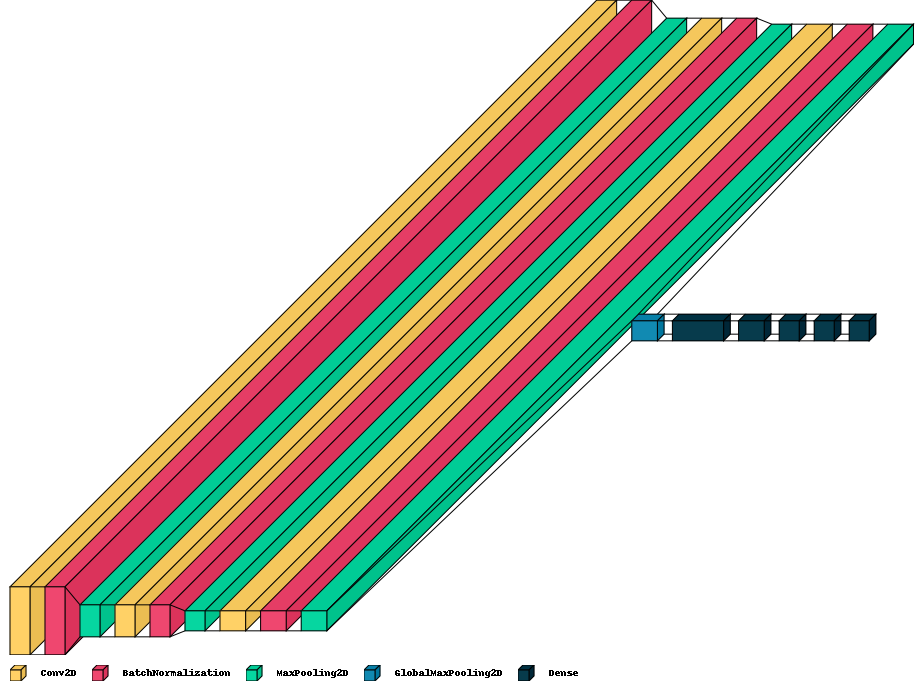

In [19]:
#with tf.device('/device:GPU:0'):
cnn = tf.keras.Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(440, 17, 1), padding='same'),
  BatchNormalization(),
  MaxPooling2D((1, 2)),

  Conv2D(64, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),#
  MaxPooling2D((1, 2)),

  Conv2D(256, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),#
  MaxPooling2D((1, 2)),

  GlobalMaxPooling2D(),

  #Dense(1024, activation='relu'),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(7)
])

cnn.compile(optimizer='adam', loss='mse', metrics=[METRICS])
cnn.summary()
plot_model(cnn, to_file=f'figures/cnn_{model_version}.png', show_shapes=True, show_layer_names=False)
visualkeras.layered_view(cnn, legend=True, to_file=f'figures/cnn_{model_version}_3d.png', spacing = 15)

In [20]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, restore_best_weights=True)
history = cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, verbose = 1, callbacks=[early_stopping])

Epoch 1/100
265/265 [==============================] - 12s 23ms/step - loss: 1.2022 - rmse: 1.0198 - mae: 0.6500 - r2score: 0.1173 - e1_mse: 1.8503 - e2_mse: 4.2536 - e1_mae: 1.0058 - e2_mae: 1.7068 - e1_rmse: 1.2914 - e2_rmse: 2.0305 - e1_r2score: -0.6594 - e2_r2score: -0.2542 - val_loss: 6.3697 - val_rmse: 2.5238 - val_mae: 1.8029 - val_r2score: -3.3378 - val_e1_mse: 10.0214 - val_e2_mse: 19.5764 - val_e1_mae: 2.7404 - val_e2_mae: 3.8418 - val_e1_rmse: 3.1484 - val_e2_rmse: 4.4106 - val_e1_r2score: 0.7577 - val_e2_r2score: 0.7559
Epoch 2/100
265/265 [==============================] - 5s 19ms/step - loss: 0.7986 - rmse: 0.8937 - mae: 0.5773 - r2score: 0.3778 - e1_mse: 1.1113 - e2_mse: 3.1823 - e1_mae: 0.7586 - e2_mae: 1.4352 - e1_rmse: 1.0346 - e2_rmse: 1.7647 - e1_r2score: -1.4373 - e2_r2score: -0.6321 - val_loss: 4.2157 - val_rmse: 2.0532 - val_mae: 1.4655 - val_r2score: -2.2858 - val_e1_mse: 7.1856 - val_e2_mse: 10.8171 - val_e1_mae: 2.2326 - val_e2_mae: 2.7060 - val_e1_rmse: 2.661

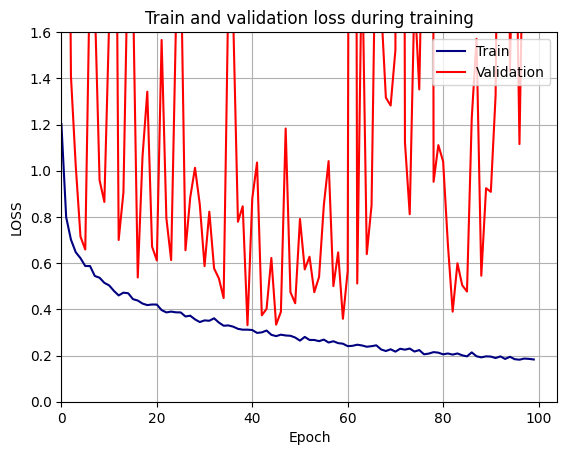

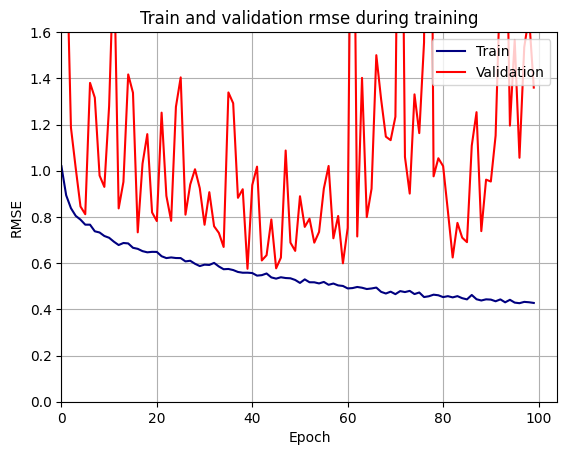

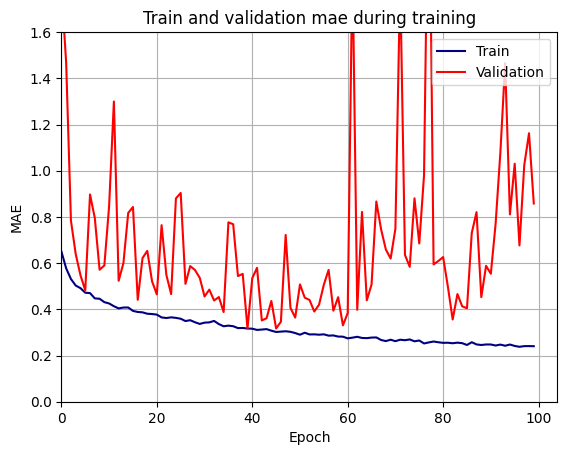

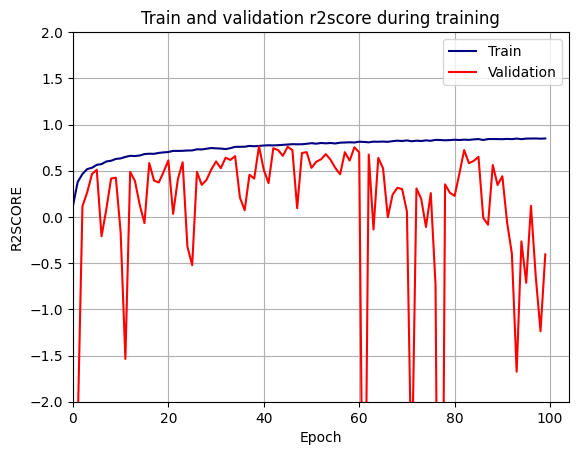

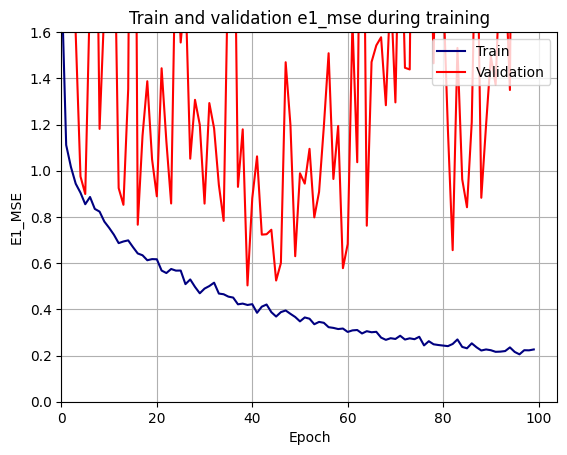

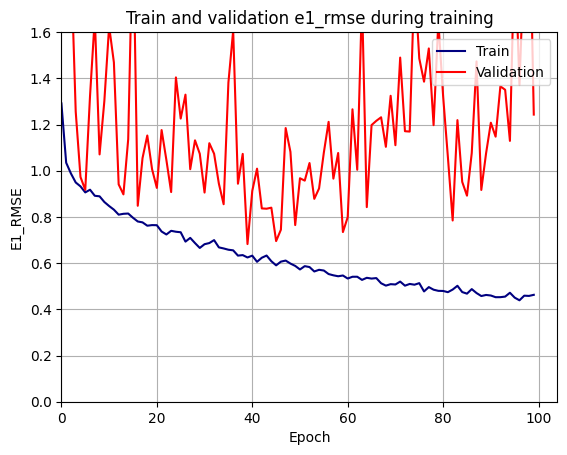

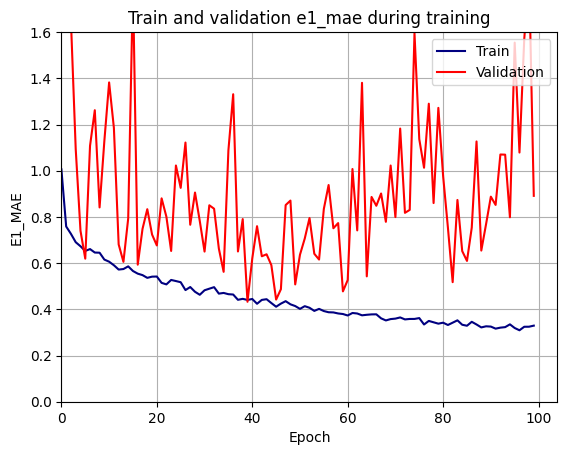

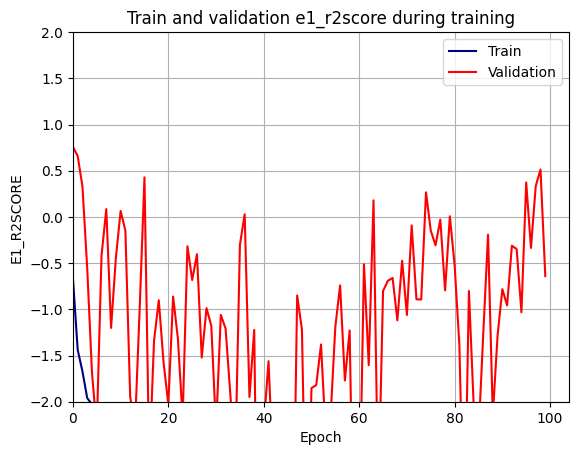

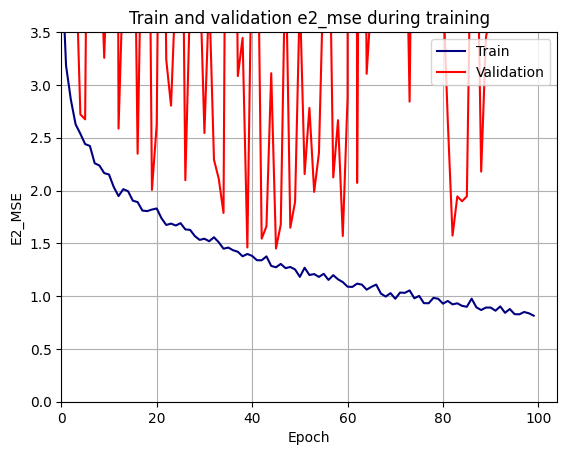

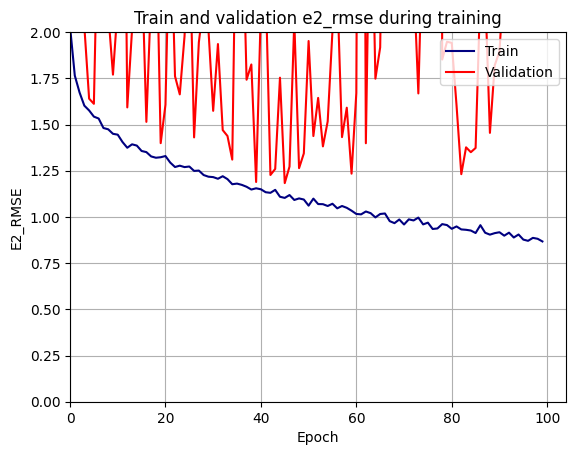

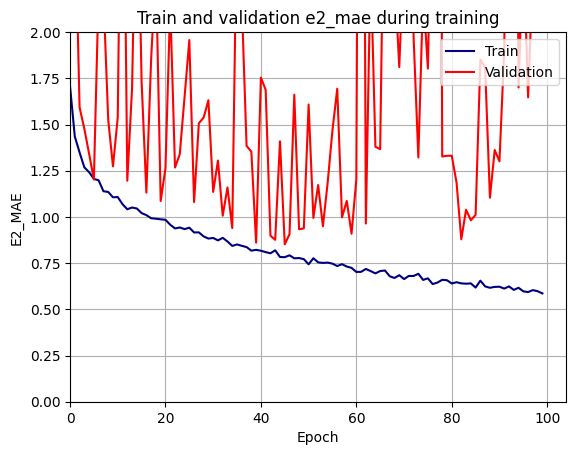

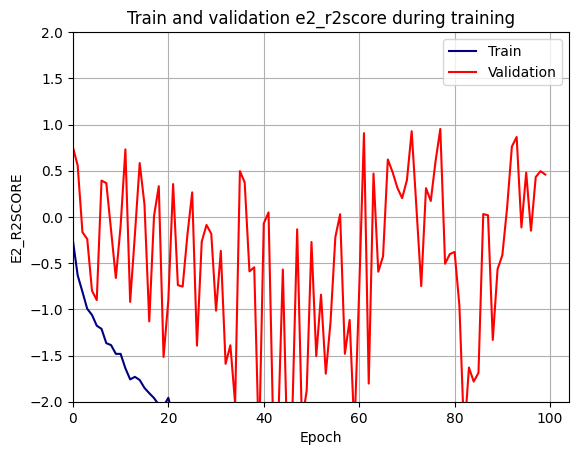

In [21]:
model = 'cnn'
variation = 'small'
plot_metrics(history, 'loss', file = f'./figures/mse_{variation}_{model}_{model_version}')
plot_metrics(history, 'rmse', file = f'./figures/rmse_{variation}_{model}_{model_version}')
plot_metrics(history, 'mae', file = f'./figures/mae_{variation}_{model}_{model_version}')
plot_metrics(history, 'r2score', file = f'./figures/r2score_{variation}_{model}_{model_version}', lim_y_bottom = -2, lim_y_top = 2)
plot_metrics(history, 'e1_mse', file = f'./figures/e1_mse_{variation}_{model}_{model_version}')
plot_metrics(history, 'e1_rmse', file = f'./figures/e1_rmse_{variation}_{model}_{model_version}')
plot_metrics(history, 'e1_mae', file = f'./figures/e1_mae{variation}_{model}_{model_version}')
plot_metrics(history, 'e1_r2score', file = f'./figures/e1_r2score_{variation}_{model}_{model_version}', lim_y_bottom = -2, lim_y_top = 2)
plot_metrics(history, 'e2_mse', file = f'./figures/e2_mse_{variation}_{model}_{model_version}', lim_y_top = 3.5)
plot_metrics(history, 'e2_rmse', file = f'./figures/e2_rmse_{variation}_{model}_{model_version}', lim_y_top = 2)
plot_metrics(history, 'e2_mae', file = f'./figures/e2_mae_{variation}_{model}_{model_version}', lim_y_top = 2)
plot_metrics(history, 'e2_r2score', file = f'./figures/e2_r2score_{variation}_{model}_{model_version}', lim_y_bottom = -2, lim_y_top = 2)

In [22]:
model_evaluation(cnn, X_test, y_test, random_samples = 10)

89/89 [==============================] - 1s 7ms/step - loss: 1.8604 - rmse: 1.3640 - mae: 0.8565 - r2score: -0.3503 - e1_mse: 1.5743 - e2_mse: 9.0811 - e1_mae: 0.8716 - e2_mae: 2.5400 - e1_rmse: 1.2301 - e2_rmse: 3.0003 - e1_r2score: -0.7428 - e2_r2score: 0.4359
Test mse: 1.860435962677002
Test rmse: 1.3639779090881348
Test mae: 0.8565043807029724
Test R2: -0.3502666652202606
89/89 [==============================] - 1s 5ms/step
Metrics for parameters e1 and e2:
Parameter e1:
  	MSE: 1.575, RMSE: 1.255, MAE: 1.575, R2: -0.639
Parameter e2:
  	MSE: 9.105, RMSE: 3.017, MAE: 19.884, R2: 0.437
1/1 [==============================] - 0s 130ms/step

Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 -0.845	3.891	0.348	0.009	-0.171	3.236	4.376
prediction:	 0.235	4.088	2.317	0.048	-0.123	1.508	6.198
------------
real:		 1.711	2.353	1.114	0.662	-0.525	4.043	5.365
prediction:	 1.100	2.814	1.983	0.359	-0.462	3.055	9.497
------------
real:		 -0.225	5.722	0.938	0.315	0.

# Recurrent Neural Network with simple RNN layer

In [16]:
model_version = '1'

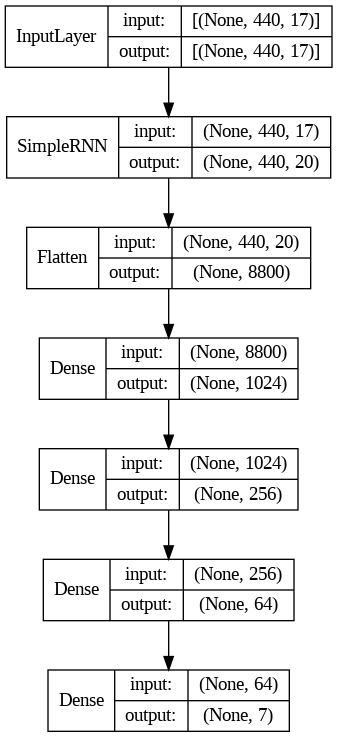

In [17]:
#with tf.device('/device:GPU:0'):
rnn = tf.keras.Sequential([
    SimpleRNN(20, input_shape=(440, 17), return_sequences=True),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7)
])

rnn.compile(optimizer='adam', loss='mse', metrics=METRICS)
#rnn.summary()
plot_model(rnn, to_file=f'figures/rnn_{model_version}.png', show_shapes=True, show_layer_names=False)
#visualkeras.layered_view(rnn, legend=True, to_file='figures/rnn_2.png', spacing = 15)

In [18]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, restore_best_weights=True)
history = rnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, verbose = 1, callbacks=[early_stopping])

Epoch 1/100
265/265 [==============================] - 61s 213ms/step - loss: 1.2857 - rmse: 1.1339 - mae: 0.7502 - r2score: 0.0439 - e1_mse: 1.8411 - e2_mse: 4.9481 - e1_mae: 1.0436 - e2_mae: 1.8740 - e1_rmse: 1.3224 - e2_rmse: 2.2068 - e1_r2score: -0.4801 - e2_r2score: -0.0196 - val_loss: 1.0590 - val_rmse: 1.0291 - val_mae: 0.6637 - val_r2score: 0.2754 - val_e1_mse: 1.4638 - val_e2_mse: 4.4372 - val_e1_mae: 0.9422 - val_e2_mae: 1.7550 - val_e1_rmse: 1.1886 - val_e2_rmse: 2.0929 - val_e1_r2score: -0.7892 - val_e2_r2score: -0.0681
Epoch 2/100
265/265 [==============================] - 55s 209ms/step - loss: 0.9992 - rmse: 0.9996 - mae: 0.6334 - r2score: 0.3305 - e1_mse: 1.3258 - e2_mse: 4.2642 - e1_mae: 0.8483 - e2_mae: 1.7295 - e1_rmse: 1.1308 - e2_rmse: 2.0500 - e1_r2score: -1.0065 - e2_r2score: -0.1747 - val_loss: 0.9264 - val_rmse: 0.9625 - val_mae: 0.5974 - val_r2score: 0.3565 - val_e1_mse: 1.2769 - val_e2_mse: 4.0340 - val_e1_mae: 0.8543 - val_e2_mae: 1.6322 - val_e1_rmse: 1.106

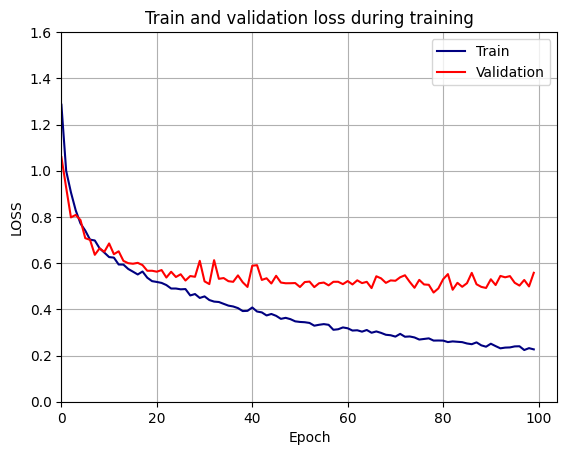

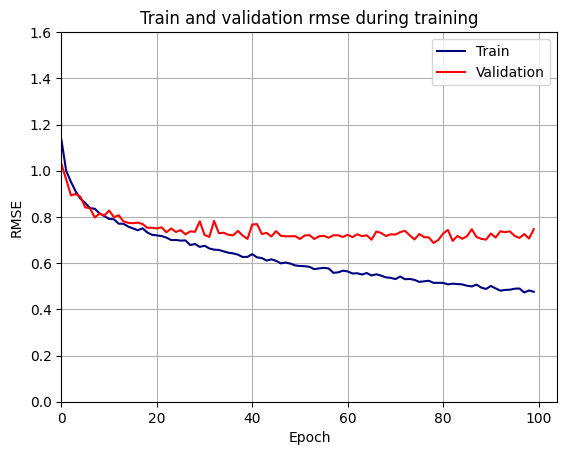

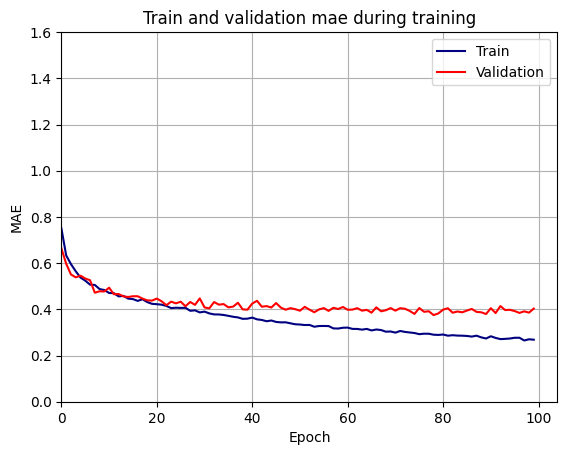

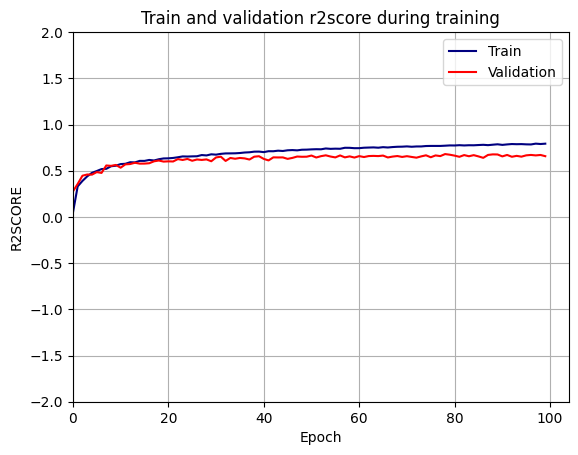

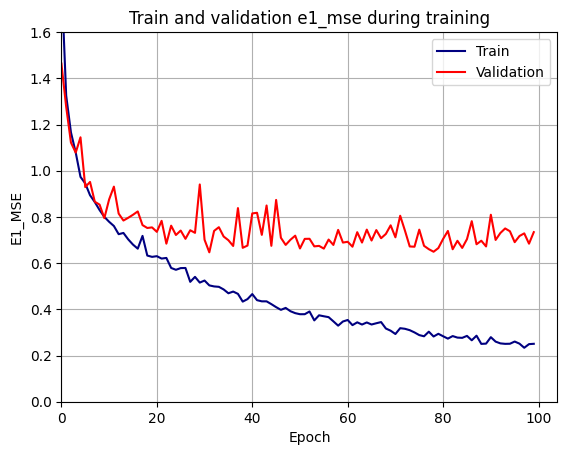

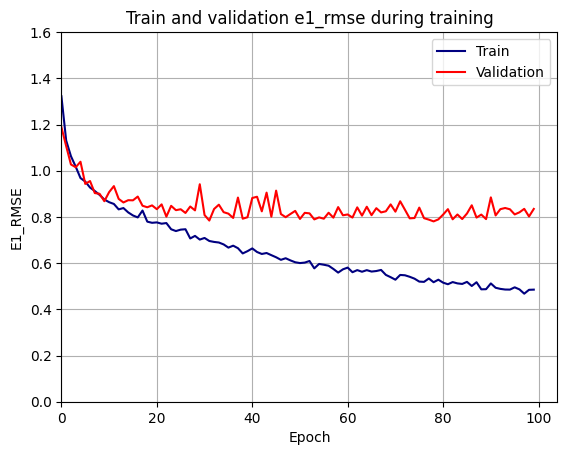

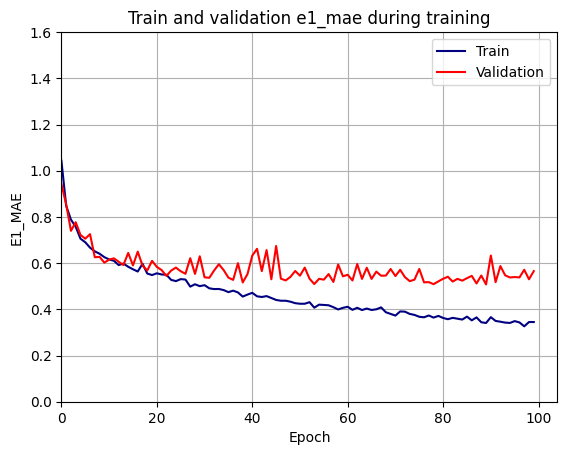

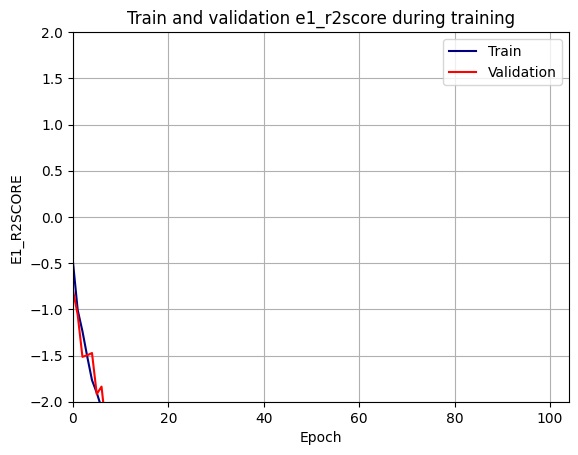

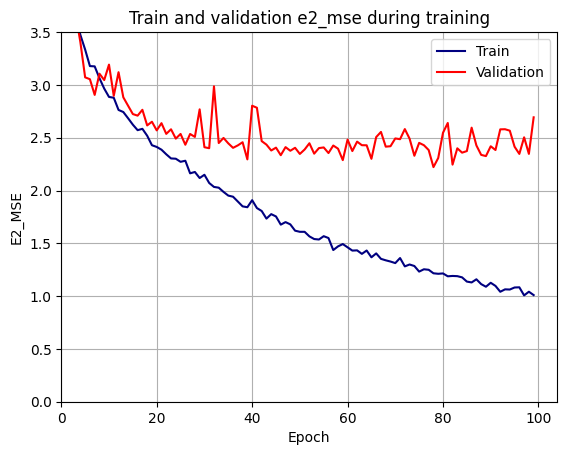

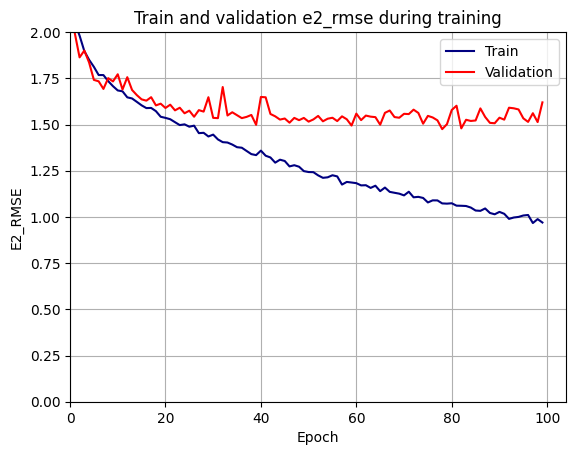

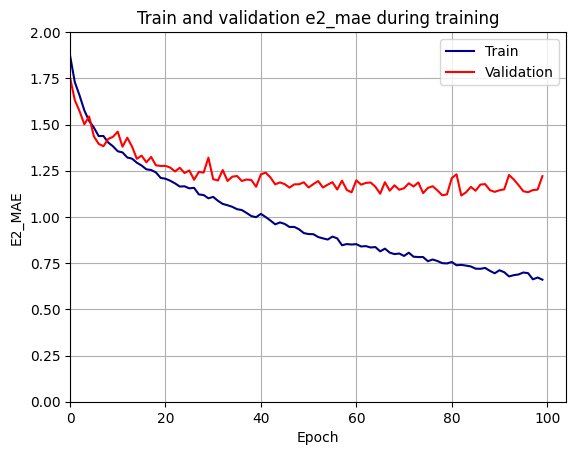

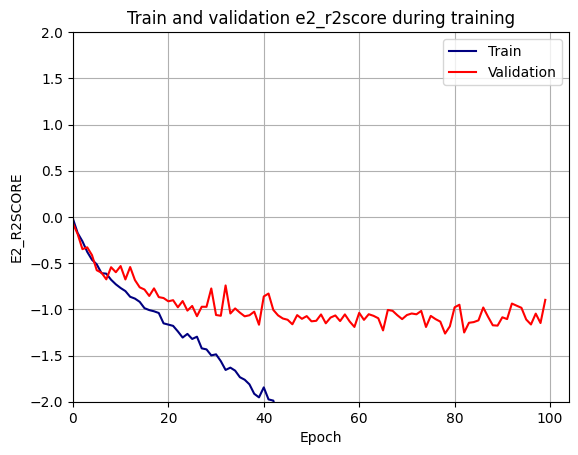

In [19]:
model = 'rnn'
variation = 'small'
plot_metrics(history, 'loss', file = f'./figures/mse_{variation}_{model}_{model_version}')
plot_metrics(history, 'rmse', file = f'./figures/rmse_{variation}_{model}_{model_version}')
plot_metrics(history, 'mae', file = f'./figures/mae_{variation}_{model}_{model_version}')
plot_metrics(history, 'r2score', file = f'./figures/r2score_{variation}_{model}_{model_version}', lim_y_bottom = -2, lim_y_top = 2)
plot_metrics(history, 'e1_mse', file = f'./figures/e1_mse_{variation}_{model}_{model_version}')
plot_metrics(history, 'e1_rmse', file = f'./figures/e1_rmse_{variation}_{model}_{model_version}')
plot_metrics(history, 'e1_mae', file = f'./figures/e1_mae{variation}_{model}_{model_version}')
plot_metrics(history, 'e1_r2score', file = f'./figures/e1_r2score_{variation}_{model}_{model_version}', lim_y_bottom = -2, lim_y_top = 2)
plot_metrics(history, 'e2_mse', file = f'./figures/e2_mse_{variation}_{model}_{model_version}', lim_y_top = 3.5)
plot_metrics(history, 'e2_rmse', file = f'./figures/e2_rmse_{variation}_{model}_{model_version}', lim_y_top = 2)
plot_metrics(history, 'e2_mae', file = f'./figures/e2_mae_{variation}_{model}_{model_version}', lim_y_top = 2)
plot_metrics(history, 'e2_r2score', file = f'./figures/e2_r2score_{variation}_{model}_{model_version}', lim_y_bottom = -2, lim_y_top = 2)

In [20]:
model_evaluation(rnn, X_test, y_test, random_samples = 10)

89/89 [==============================] - 4s 41ms/step - loss: 0.5641 - rmse: 0.7511 - mae: 0.4094 - r2score: 0.6527 - e1_mse: 0.7278 - e2_mse: 2.6900 - e1_mae: 0.5741 - e2_mae: 1.2229 - e1_rmse: 0.8319 - e2_rmse: 1.6136 - e1_r2score: -3.0157 - e2_r2score: -1.8261
Test mse: 0.5641028881072998
Test rmse: 0.7510679364204407
Test mae: 0.40941551327705383
Test R2: 0.6527112722396851
89/89 [==============================] - 4s 39ms/step
Metrics for parameters e1 and e2:
Parameter e1:
  	MSE: 0.733, RMSE: 0.856, MAE: 0.733, R2: -2.524
Parameter e2:
  	MSE: 2.717, RMSE: 1.648, MAE: 10.780, R2: -0.885
1/1 [==============================] - 0s 52ms/step

Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 1.107	5.046	2.989	0.762	0.058	0.938	5.127
prediction:	 1.670	5.725	2.932	0.958	0.292	1.107	6.674
------------
real:		 2.285	4.053	1.878	1.629	0.352	2.116	6.703
prediction:	 2.506	3.604	2.189	1.473	0.039	2.607	5.820
------------
real:		 -0.212	3.304	0.944	0.086	0.08

#  Recurrent Neural Network Model with LSTM

In [21]:
model_version = '1'

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 440, 20)           3040      
                                                                 
 flatten_2 (Flatten)         (None, 8800)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              9012224   
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dense_12 (Dense)            (None, 64)               

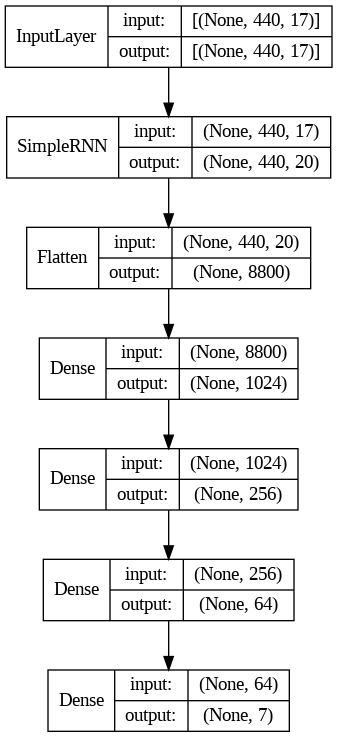

In [22]:
#with tpu_strategy.scope():
rnn_lstm = tf.keras.Sequential([
    LSTM(20, input_shape=(440, 17), return_sequences = True),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7)
])

rnn_lstm.compile(optimizer='adam', loss='mse', metrics=METRICS)
rnn_lstm.summary()
plot_model(rnn, to_file=f'figures/rnnlstm_{model_version}.png', show_shapes=True, show_layer_names=False)
#visualkeras.layered_view(rnn, legend=True, to_file='figures/rnnlstm_2.png', spacing = 15)

In [23]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=1, restore_best_weights=True)
history = rnn_lstm.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=100, verbose = 1, callbacks=[early_stopping])

Epoch 1/100
265/265 [==============================] - 11s 27ms/step - loss: 1.3787 - rmse: 1.0840 - mae: 0.6913 - r2score: 0.1623 - e1_mse: 2.0497 - e2_mse: 5.0423 - e1_mae: 1.1092 - e2_mae: 1.8811 - e1_rmse: 1.3946 - e2_rmse: 2.2147 - e1_r2score: -0.3848 - e2_r2score: -0.0242 - val_loss: 1.0676 - val_rmse: 1.0332 - val_mae: 0.6721 - val_r2score: 0.2128 - val_e1_mse: 1.2955 - val_e2_mse: 4.3021 - val_e1_mae: 0.8166 - val_e2_mae: 1.7174 - val_e1_rmse: 1.1104 - val_e2_rmse: 2.0600 - val_e1_r2score: -1.0743 - val_e2_r2score: -0.1057
Epoch 2/100
265/265 [==============================] - 6s 22ms/step - loss: 1.0491 - rmse: 1.0242 - mae: 0.6673 - r2score: 0.2612 - e1_mse: 1.2843 - e2_mse: 4.2923 - e1_mae: 0.8373 - e2_mae: 1.7339 - e1_rmse: 1.1165 - e2_rmse: 2.0572 - e1_r2score: -1.0232 - e2_r2score: -0.1676 - val_loss: 0.9346 - val_rmse: 0.9667 - val_mae: 0.6228 - val_r2score: 0.2997 - val_e1_mse: 1.1387 - val_e2_mse: 3.9085 - val_e1_mae: 0.7660 - val_e2_mae: 1.5924 - val_e1_rmse: 1.0382 -

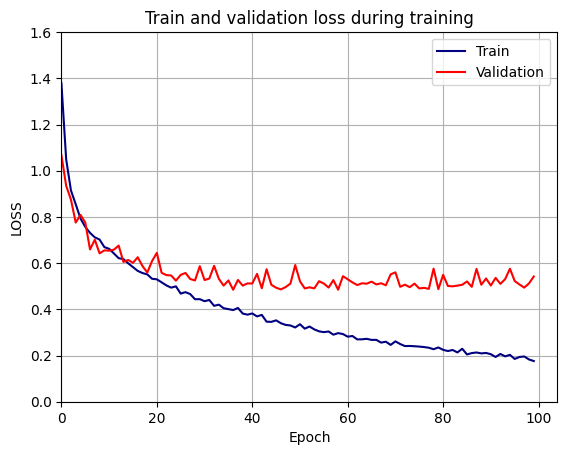

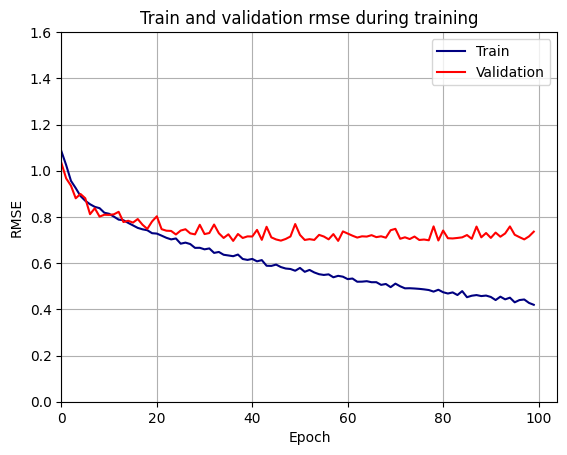

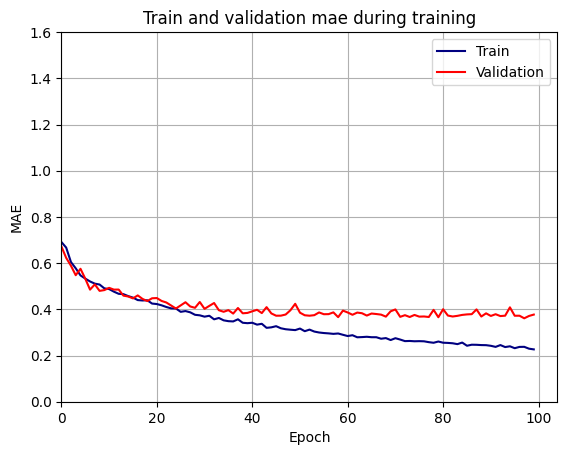

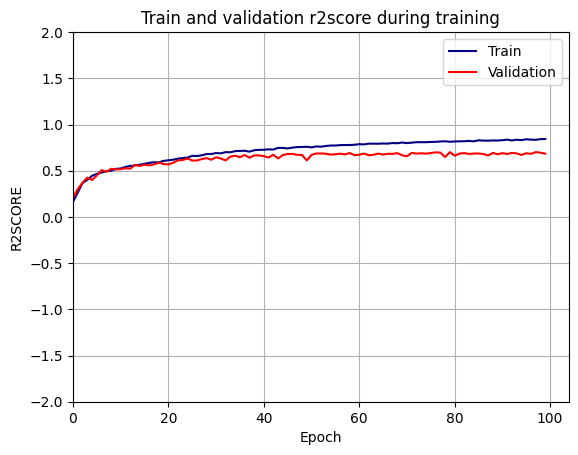

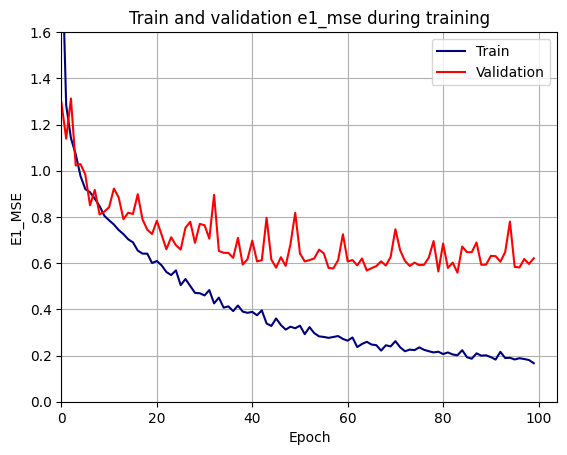

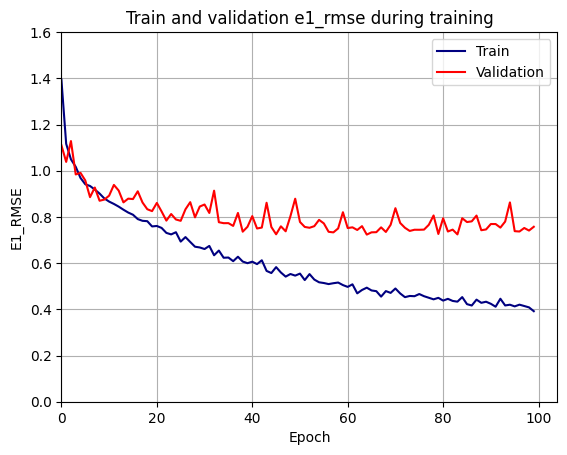

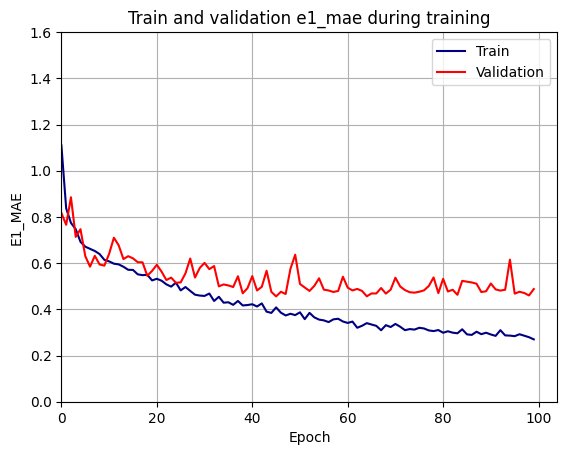

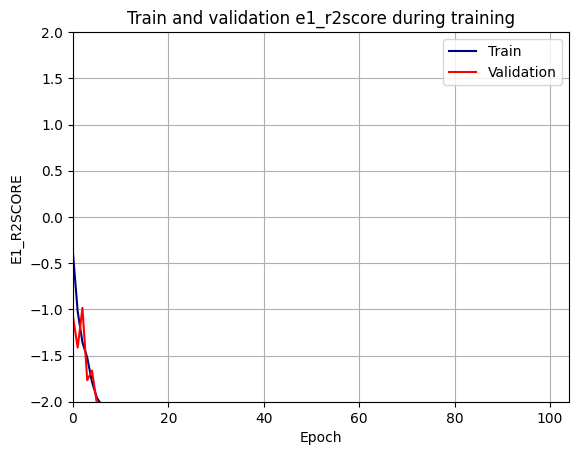

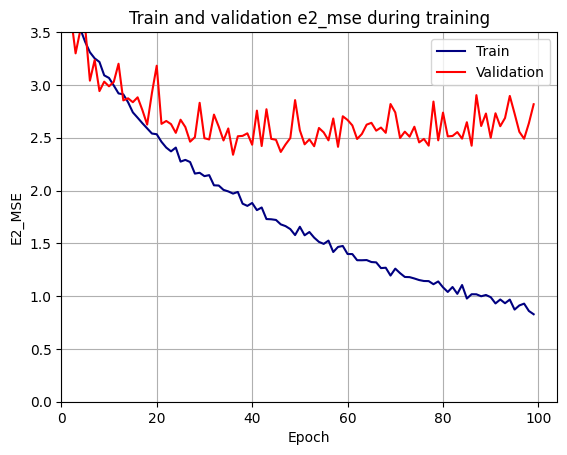

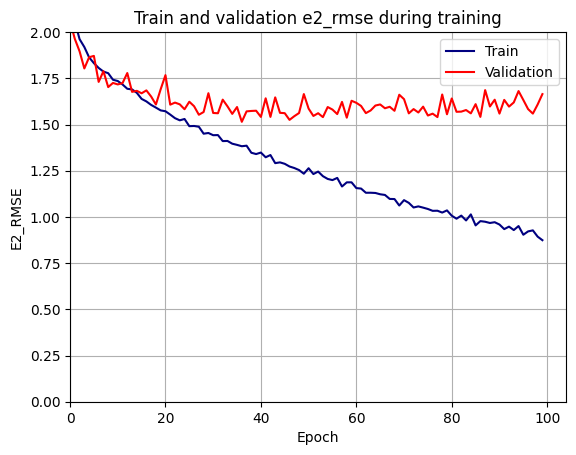

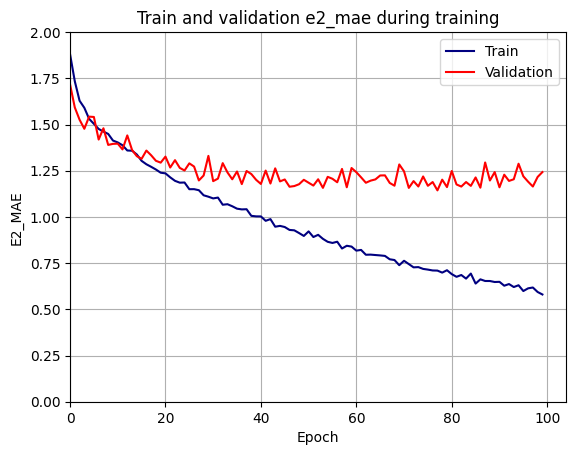

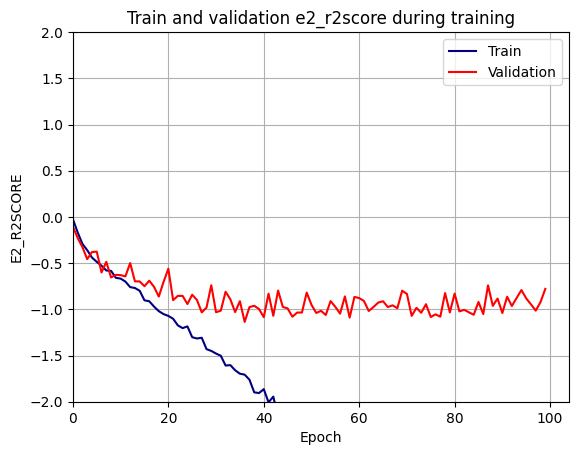

In [24]:
model = 'rnn_lstm'
variation = 'small'
plot_metrics(history, 'loss', file = f'./figures/mse_{variation}_{model}_{model_version}')
plot_metrics(history, 'rmse', file = f'./figures/rmse_{variation}_{model}_{model_version}')
plot_metrics(history, 'mae', file = f'./figures/mae_{variation}_{model}_{model_version}')
plot_metrics(history, 'r2score', file = f'./figures/r2score_{variation}_{model}_{model_version}', lim_y_bottom = -2, lim_y_top = 2)
plot_metrics(history, 'e1_mse', file = f'./figures/e1_mse_{variation}_{model}_{model_version}')
plot_metrics(history, 'e1_rmse', file = f'./figures/e1_rmse_{variation}_{model}_{model_version}')
plot_metrics(history, 'e1_mae', file = f'./figures/e1_mae{variation}_{model}_{model_version}')
plot_metrics(history, 'e1_r2score', file = f'./figures/e1_r2score_{variation}_{model}_{model_version}', lim_y_bottom = -2, lim_y_top = 2)
plot_metrics(history, 'e2_mse', file = f'./figures/e2_mse_{variation}_{model}_{model_version}', lim_y_top = 3.5)
plot_metrics(history, 'e2_rmse', file = f'./figures/e2_rmse_{variation}_{model}_{model_version}', lim_y_top = 2)
plot_metrics(history, 'e2_mae', file = f'./figures/e2_mae_{variation}_{model}_{model_version}', lim_y_top = 2)
plot_metrics(history, 'e2_r2score', file = f'./figures/e2_r2score_{variation}_{model}_{model_version}', lim_y_bottom = -2, lim_y_top = 2)

In [25]:
model_evaluation(rnn_lstm, X_test, y_test,random_samples = 10)

89/89 [==============================] - 1s 10ms/step - loss: 0.5814 - rmse: 0.7625 - mae: 0.3910 - r2score: 0.6781 - e1_mse: 0.6031 - e2_mse: 3.0280 - e1_mae: 0.4898 - e2_mae: 1.2963 - e1_rmse: 0.7513 - e2_rmse: 1.7208 - e1_r2score: -4.3043 - e2_r2score: -0.7727
Test mse: 0.5813601613044739
Test rmse: 0.7624697089195251
Test mae: 0.3909871280193329
Test R2: 0.6781395673751831
89/89 [==============================] - 1s 8ms/step
Metrics for parameters e1 and e2:
Parameter e1:
  	MSE: 0.608, RMSE: 0.779, MAE: 0.608, R2: -3.250
Parameter e2:
  	MSE: 3.050, RMSE: 1.747, MAE: 10.196, R2: -0.679
1/1 [==============================] - 0s 27ms/step

Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 1.595	3.343	1.026	0.207	-0.068	4.236	6.694
prediction:	 1.780	3.103	1.226	0.305	0.081	3.106	4.007
------------
real:		 -1.714	4.176	2.534	1.324	0.249	6.012	2.814
prediction:	 -1.802	4.205	2.234	1.528	0.266	3.669	5.170
------------
real:		 0.911	3.862	2.762	1.141	-0.0